# Text similarity evaluation

In [1]:
import pandas as pd

# testing dataset
df = pd.read_csv("../../data/minors_with_preprocessed_descriptions.csv")

### Import embeddings

In [2]:
import joblib
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import tensorflow_hub as hub

# TF-IDF
tfidf_vectorizer = joblib.load('../../models/preprocessing/tfidf_vectorizer.pkl')

# Doc2Vec
doc2vec_model = Doc2Vec.load('../../models/preprocessing/doc2vec_model.model')

#USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

# sBERT
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# sBERT fine-tuned
sbert_fine_tuned_model = SentenceTransformer('../../models/preprocessing/sbert_fine_tuned_model')

# RoBERTa
roberta_tokenizer = AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")
roberta_model = AutoModel.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

# RoBERTa fine-tuned
roberta_fine_tuned_model = SentenceTransformer('../../models/preprocessing/roberta_fine_tuned_model')

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid resu

In [4]:
models_list = [
    ('TF-IDF', tfidf_vectorizer),
    ('Doc2Vec', doc2vec_model),
    ('USE', use_model),
    ('sBERT', sbert_model),
    ('sBERT Fine-Tuned', sbert_fine_tuned_model),
    ('RoBERTa', roberta_model),
    ('RoBERTa Fine-Tuned', roberta_fine_tuned_model)
]

## 1. Semtantic Textual Similarity Spanish benchmark

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

def embed_sentences(sentences, model_type):
    if model_type == 'tfidf':
        return tfidf_vectorizer.transform(sentences).toarray()
    elif model_type == 'doc2vec':
        return np.array([doc2vec_model.infer_vector(sentence.split()) for sentence in sentences])
    elif model_type == 'use':
        return use_model(sentences).numpy()
    elif model_type == 'sbert':
        embeddings = sbert_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings
    elif model_type == 'sbert_fine_tuned':
        embeddings = sbert_fine_tuned_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings
    elif model_type == 'roberta':
        inputs = roberta_tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = roberta_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    elif model_type == 'roberta_fine_tuned':
        embeddings = roberta_fine_tuned_model.encode(sentences, convert_to_tensor=True)
        return embeddings.cpu().numpy() if torch.is_tensor(embeddings) else embeddings

# Embed sentences
def get_embeddings(dataset_split, model_type):
    sentence1_embeddings = embed_sentences(dataset_split['sentence1'], model_type)
    sentence2_embeddings = embed_sentences(dataset_split['sentence2'], model_type)
    return sentence1_embeddings, sentence2_embeddings


In [5]:
def compute_cosine_similarity(embeddings1, embeddings2):
    return np.diag(cosine_similarity(embeddings1, embeddings2))

def evaluate_performance(dataset_split, model_type):
    sentence1_embeddings, sentence2_embeddings = get_embeddings(dataset_split, model_type)
    cosine_similarities = compute_cosine_similarity(sentence1_embeddings, sentence2_embeddings)
    labels = np.array(dataset_split['label'])
    correlation = np.corrcoef(cosine_similarities, labels)[0, 1]
    return correlation


In [6]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("PlanTL-GOB-ES/sts-es")
# Evaluate on the test split for each model
test_split = dataset['test']

In [1]:
# from text_preprocessing import preprocess_text

import nltk
from nltk.corpus import stopwords
import spacy
import re

# Load spaCy's Spanish language model
nlp = spacy.load('es_core_news_sm')

# Download NLTK stop words
nltk.download('stopwords')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define Spanish stop words
spanish_stopwords = set(stopwords.words('spanish'))

# Load spaCy's Spanish language model
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text, language='spanish')
    
    # Remove unnecessary information (personal information, days, months)
    tokens = [re.sub(r'\b\d{2,}\b|(?:\d{1,2}[\/\-\.]){2,}\d{2,4}|\b(?:tel|email)\b', '', token) for token in tokens]
    tokens = [token for token in tokens if token.lower() not in ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo', 'enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]
    
    # Remove non-alphabetic characters
    tokens = [re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ]', '', token) for token in tokens]
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in spanish_stopwords]
    
    # Lemmatization
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)



def preprocess_dataset(example):
    example['sentence1'] = preprocess_text(example['sentence1'])
    example['sentence2'] = preprocess_text(example['sentence2'])
    return example

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
preprocessed_test_split = test_split.map(preprocess_dataset)

Map: 100%|██████████| 155/155 [00:01<00:00, 79.42 examples/s]


In [8]:
tfidf_score = evaluate_performance(preprocessed_test_split, 'tfidf')
doc2vec_score = evaluate_performance(preprocessed_test_split, 'doc2vec')
use_score = evaluate_performance(preprocessed_test_split, 'use')
sbert_score = evaluate_performance(preprocessed_test_split, 'sbert')
sbert_fine_tuned_score = evaluate_performance(preprocessed_test_split, 'sbert_fine_tuned')
roberta_score = evaluate_performance(preprocessed_test_split, 'roberta')
roberta_fine_tuned_score = evaluate_performance(preprocessed_test_split, 'roberta_fine_tuned')

c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [9]:
print("TF-IDF score:", tfidf_score)
print("Doc2Vec score:", doc2vec_score)
print("USE score:", use_score)
print("SBERT score:", sbert_score)
print("SBERT Fine-Tuned score:", sbert_fine_tuned_score)
print("RoBERTa score:", roberta_score)
print("RoBERTa Fine-Tuned score:", roberta_fine_tuned_score)

TF-IDF score: 0.6251690284354735
Doc2Vec score: 0.5080878139807444
USE score: 0.5888873224838592
SBERT score: 0.6638357787963985
SBERT Fine-Tuned score: 0.6728821998534976
RoBERTa score: 0.36473031119789356
RoBERTa Fine-Tuned score: 0.6002124736248321


## 2. CPV group similarity using test data

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

def calculate_similarity(model, descriptions):
    if model == tfidf_vectorizer:
        embeddings = model.transform(descriptions).toarray()
    elif model == doc2vec_model:
        embeddings = np.array([model.infer_vector(desc.split()) for desc in descriptions])
    elif model == use_model:
        embeddings = model(descriptions).numpy()
    elif model == sbert_model or model == sbert_fine_tuned_model:
        embeddings = model.encode(descriptions)
    elif model == roberta_model:
        inputs = roberta_tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    elif model == roberta_fine_tuned_model:
        embeddings = model.encode(descriptions)
    return embeddings

In [7]:
cpv_groups = df.groupby('CPV')
cpv_similarities = {}

for cpv, group in cpv_groups:
    descriptions = group['processed_description'].tolist()
    if len(descriptions) > 1:
        for name, model in models_list:
            embeddings = calculate_similarity(model, descriptions)
            cosine_sim_matrix = cosine_similarity(embeddings)
            avg_similarity = np.mean([cosine_sim_matrix[i, j] for i in range(len(cosine_sim_matrix)) for j in range(i+1, len(cosine_sim_matrix))])
            if name not in cpv_similarities:
                cpv_similarities[name] = []
            cpv_similarities[name].append(avg_similarity)

In [9]:
# Calculate overall average similarity for each model
overall_avg_similarity = {name: np.mean(similarities) for name, similarities in cpv_similarities.items()}

# Print the results
for name, avg_similarity in overall_avg_similarity.items():
    print(f"{name} Average Similarity: {avg_similarity:.4f}")

TF-IDF Average Similarity: 0.2397
Doc2Vec Average Similarity: 0.3808
USE Average Similarity: 0.5813
sBERT Average Similarity: 0.6035
sBERT Fine-Tuned Average Similarity: 0.7524
RoBERTa Average Similarity: 0.9637
RoBERTa Fine-Tuned Average Similarity: 0.7773


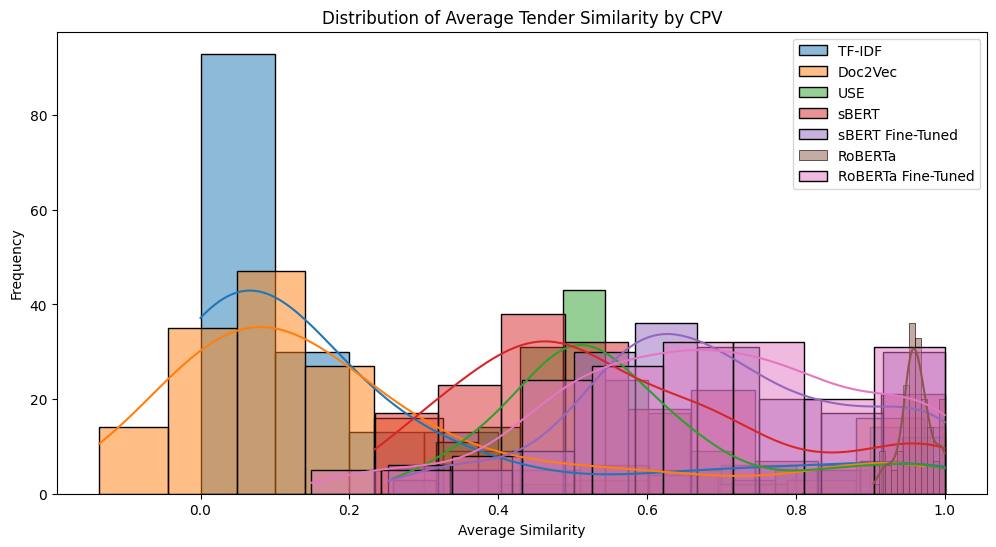

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the average tender similarity for each CPV
plt.figure(figsize=(12, 6))
for name, similarities in cpv_similarities.items():
    sns.histplot(similarities, label=name, kde=True)

plt.title('Distribution of Average Tender Similarity by CPV')
plt.xlabel('Average Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

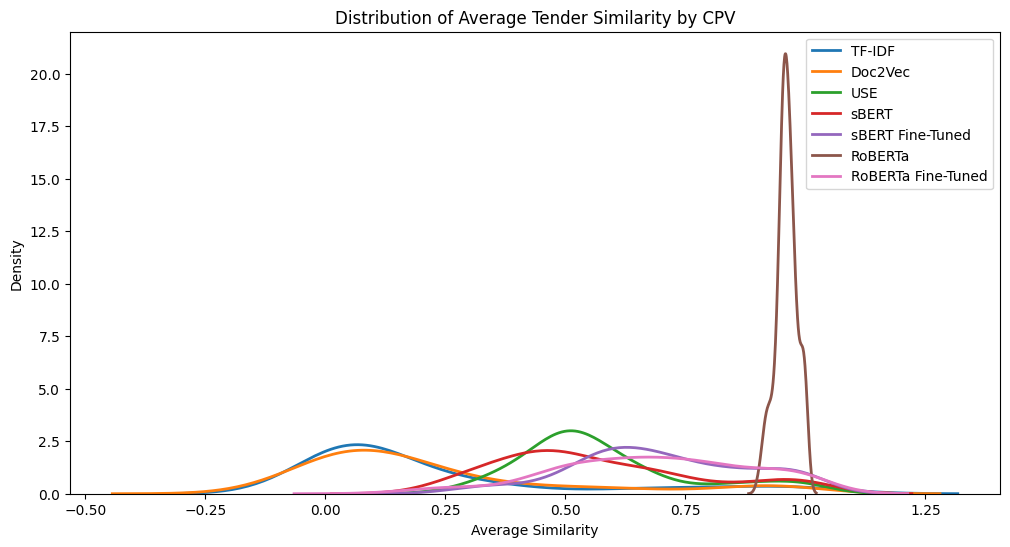

In [9]:
# Plot the distribution of the average tender similarity for each CPV without bars
plt.figure(figsize=(12, 6))
for name, similarities in cpv_similarities.items():
    sns.kdeplot(similarities, label=name, linewidth=2)

plt.title('Distribution of Average Tender Similarity by CPV')
plt.xlabel('Average Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

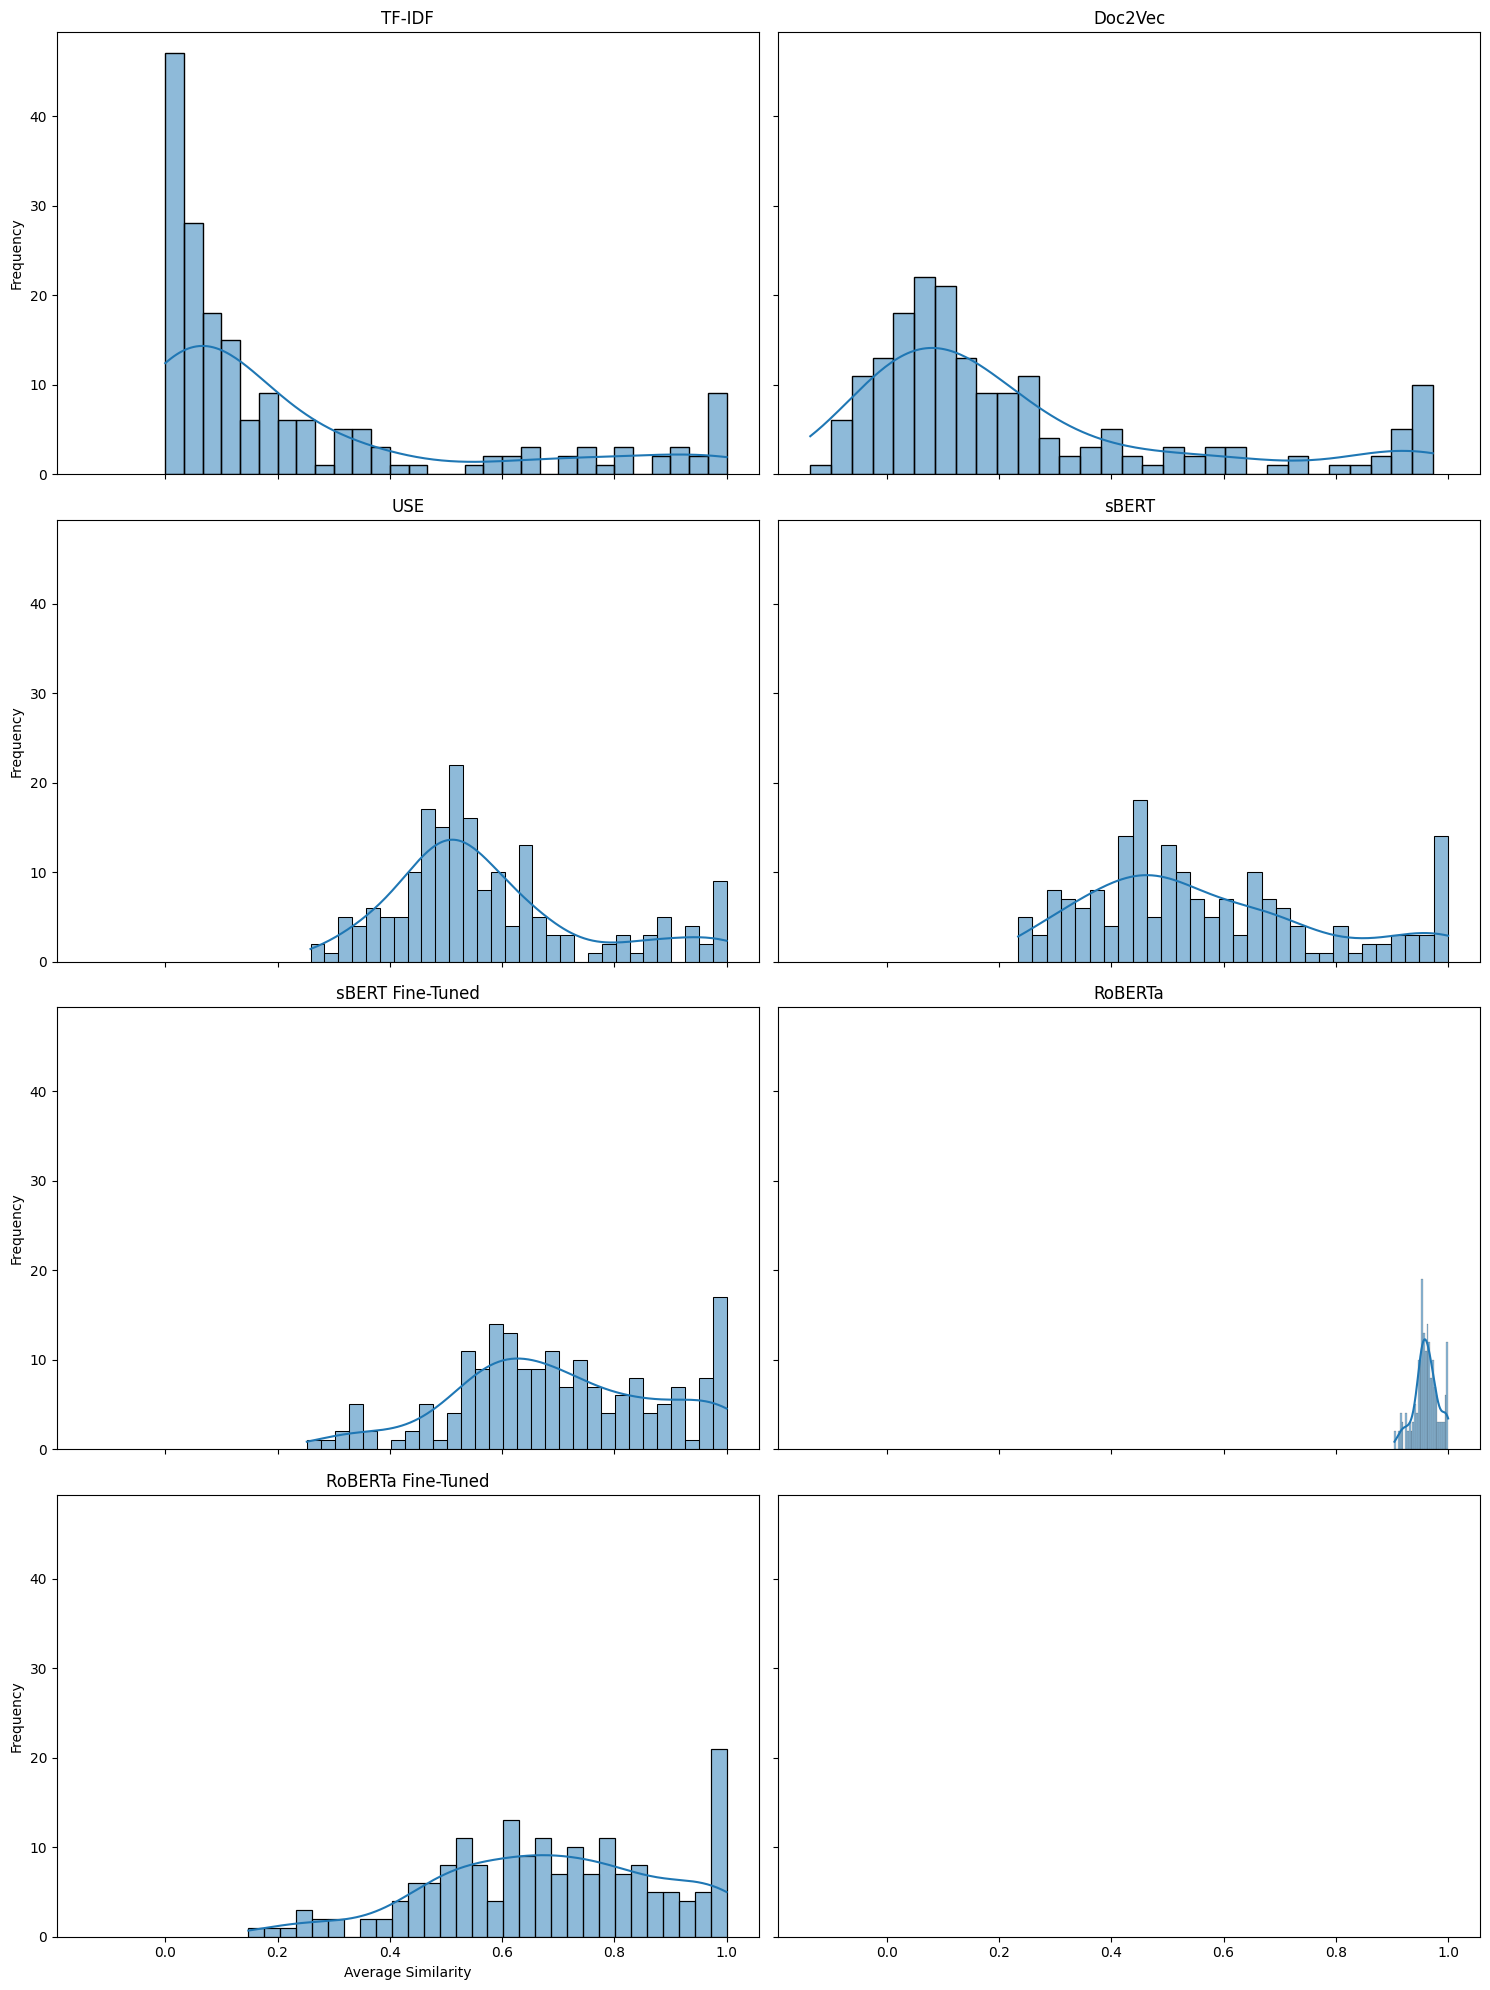

In [10]:
# Create a histogram for each model's similarity distribution
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (name, similarities) in zip(axes, cpv_similarities.items()):
    sns.histplot(similarities, bins=30, kde=True, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Average Similarity')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Cosine similarity between all tender descriptions pair-wise

In [11]:
descriptions = df['processed_description'].tolist()

# Calculate and print average pairwise cosine similarity for each model
for model_name, model in models_list:
    embeddings = calculate_similarity(model, descriptions)
    cosine_sim_matrix = cosine_similarity(embeddings)
    upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
    average_similarity = cosine_sim_matrix[upper_triangle_indices].mean()
    print(f"{model_name} Average Pairwise Cosine Similarity: {average_similarity}")

TF-IDF Average Pairwise Cosine Similarity: 0.014908945735179533
Doc2Vec Average Pairwise Cosine Similarity: 0.03446723893284798
USE Average Pairwise Cosine Similarity: 0.45917871594429016
sBERT Average Pairwise Cosine Similarity: 0.31077054142951965
sBERT Fine-Tuned Average Pairwise Cosine Similarity: 0.2703285813331604
RoBERTa Average Pairwise Cosine Similarity: 0.9575461745262146
RoBERTa Fine-Tuned Average Pairwise Cosine Similarity: 0.16894632577896118


## 3. Clustering

Apply clustering for Fine-tuned sBERT and RoBERTa

In [3]:
descriptions = df['processed_description'].tolist()

sbert_fine_tuned_embeddings = sbert_fine_tuned_model.encode(descriptions, show_progress_bar=True)
roberta_fine_tuned_embeddings = roberta_fine_tuned_model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/44 [00:00<?, ?it/s]c:\Users\Pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Batches: 100%|██████████| 44/44 [00:09<00:00,  4.73it/s]


In [4]:
print('sBERT:',sbert_fine_tuned_embeddings.shape)
print('RoBERTa:',roberta_fine_tuned_embeddings.shape)

sBERT: (1392, 384)
RoBERTa: (1392, 768)


In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_elbow_silhouette(embeddings, max_clusters=10):
    wcss = []
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(embeddings, cluster_labels))
        
    return wcss, silhouette_scores


def plot_elbow_silhouette(embeddings, title):
    wcss, silhouette_scores = calculate_elbow_silhouette(embeddings)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(range(2, len(wcss) + 2), wcss, 'g-')
    ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, 'b-')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS (Elbow Method)', color='g')
    ax2.set_ylabel('Silhouette Score', color='b')

    plt.title(title)
    plt.show()


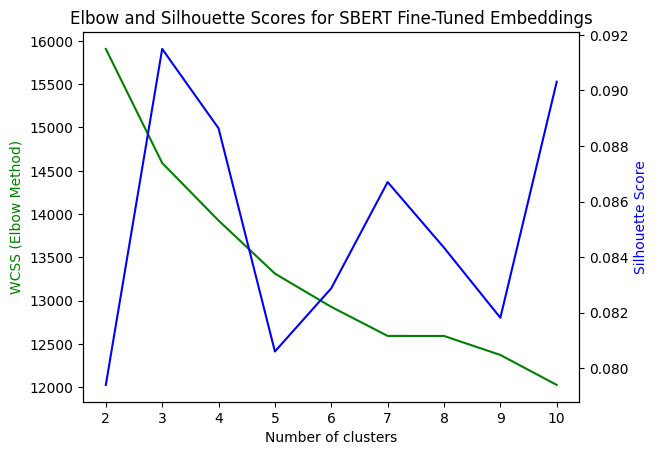

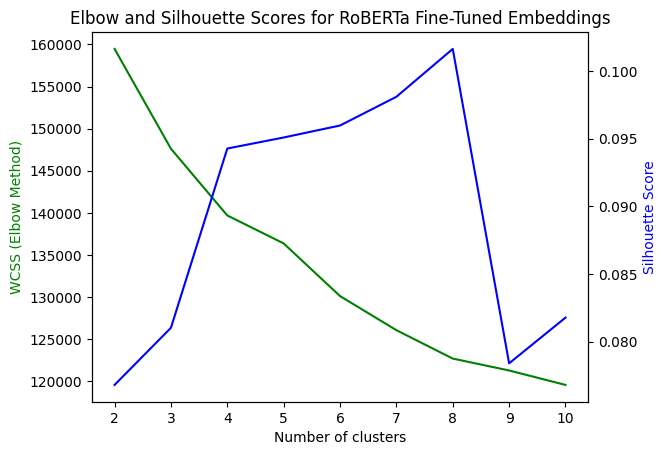

In [6]:
plot_elbow_silhouette(sbert_fine_tuned_embeddings, 'Elbow and Silhouette Scores for SBERT Fine-Tuned Embeddings')
plot_elbow_silhouette(roberta_fine_tuned_embeddings, 'Elbow and Silhouette Scores for RoBERTa Fine-Tuned Embeddings')

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {
    0: '#8d1df5',  
    1: '#ff7f0e',  
    2: '#2ca02c',  
    3: '#ff0044',  
    4: '#1cbbff', 
    5: '#ee00ff',  
    6: '#1e00ff', 
    7: '#d8f51b',  
}

def plot_clusters(embeddings_2d, labels, n_clusters, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=custom_palette)
    plt.title(f'{title} - {n_clusters} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Reduce dimensions for 2D visualization
pca = PCA(n_components=2)
sbert_embeddings_2d = pca.fit_transform(sbert_fine_tuned_embeddings)
roberta_embeddings_2d = pca.fit_transform(roberta_fine_tuned_embeddings)

sbert_clusters = [3, 7]
sbert_kmeans_models = {n_clusters: KMeans(n_clusters=n_clusters, random_state=42).fit(sbert_fine_tuned_embeddings) for n_clusters in sbert_clusters}

roberta_clusters = [4, 8]
roberta_kmeans_models = {n_clusters: KMeans(n_clusters=n_clusters, random_state=42).fit(roberta_fine_tuned_embeddings) for n_clusters in roberta_clusters}

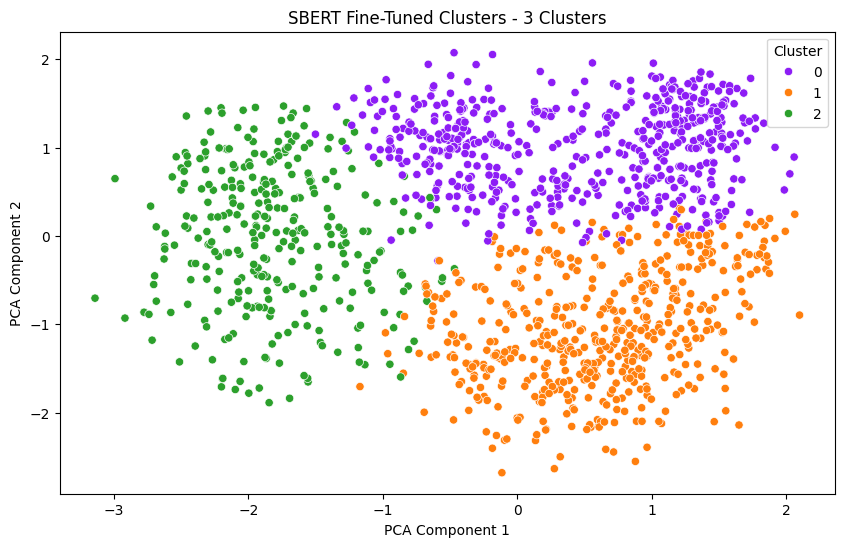

SBERT Fine-Tuned - 3 Clusters:
Silhouette Score: 0.09149307012557983
Davies-Bouldin Index: 2.823027222881905
Calinski-Harabasz Index: 126.64447234521474



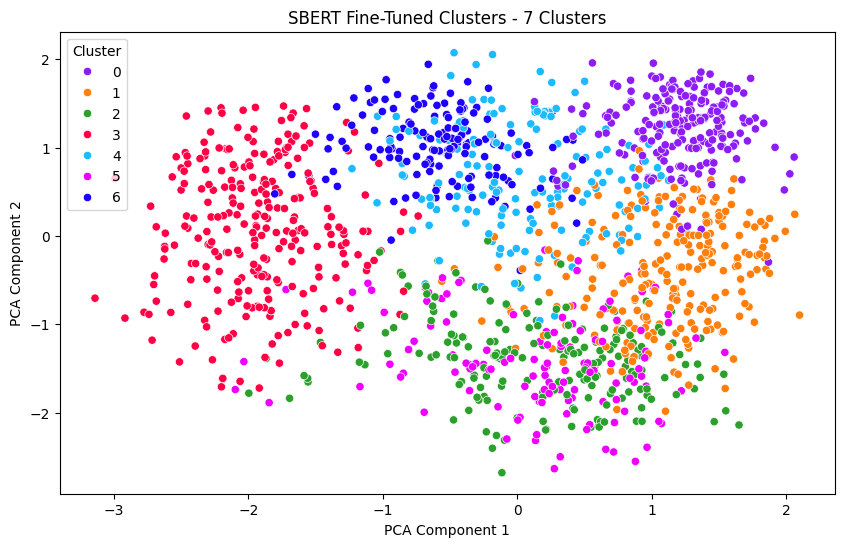

SBERT Fine-Tuned - 7 Clusters:
Silhouette Score: 0.08670160919427872
Davies-Bouldin Index: 2.631235872125272
Calinski-Harabasz Index: 85.35001351058695



In [13]:
for n_clusters, kmeans in sbert_kmeans_models.items():
    labels = kmeans.labels_
    plot_clusters(sbert_embeddings_2d, labels, n_clusters, 'SBERT Fine-Tuned Clusters')
    silhouette_avg = silhouette_score(sbert_fine_tuned_embeddings, labels)
    davies_bouldin = davies_bouldin_score(sbert_fine_tuned_embeddings, labels)
    calinski_harabasz = calinski_harabasz_score(sbert_fine_tuned_embeddings, labels)
    print(f'SBERT Fine-Tuned - {n_clusters} Clusters:')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {davies_bouldin}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz}')
    print()

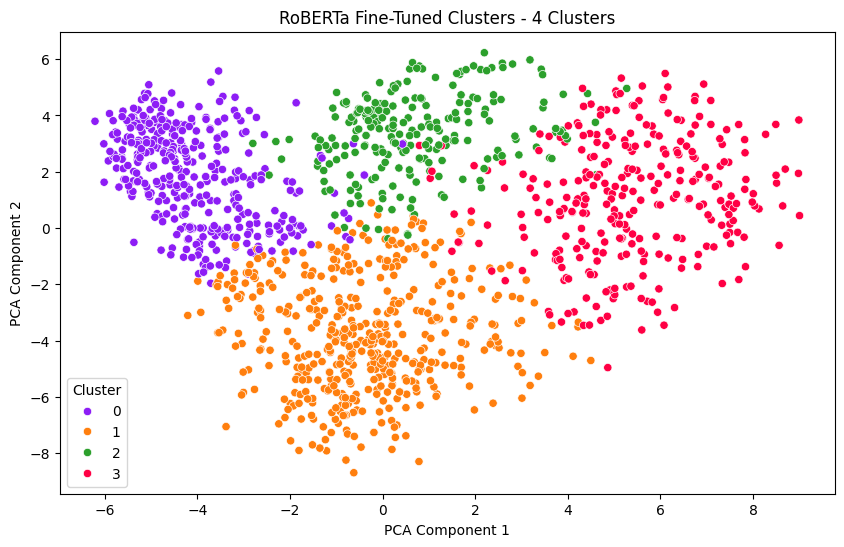

RoBERTa Fine-Tuned - 4 Clusters:
Silhouette Score: 0.09427354484796524
Davies-Bouldin Index: 2.6276960304180292
Calinski-Harabasz Index: 109.33415777100836



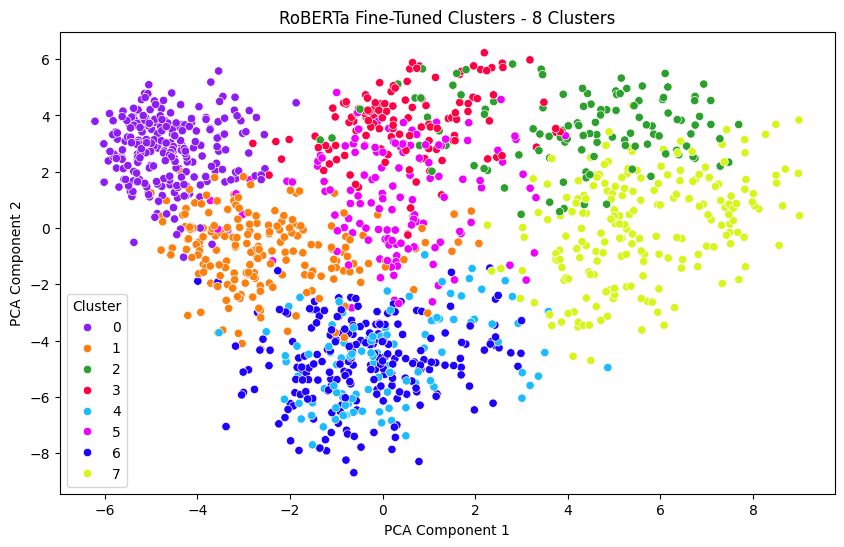

RoBERTa Fine-Tuned - 8 Clusters:
Silhouette Score: 0.10164035111665726
Davies-Bouldin Index: 2.6422293659396816
Calinski-Harabasz Index: 80.60614151564349



In [14]:
for n_clusters, kmeans in roberta_kmeans_models.items():
    labels = kmeans.labels_
    plot_clusters(roberta_embeddings_2d, labels, n_clusters, 'RoBERTa Fine-Tuned Clusters')
    silhouette_avg = silhouette_score(roberta_fine_tuned_embeddings, labels)
    davies_bouldin = davies_bouldin_score(roberta_fine_tuned_embeddings, labels)
    calinski_harabasz = calinski_harabasz_score(roberta_fine_tuned_embeddings, labels)
    print(f'RoBERTa Fine-Tuned - {n_clusters} Clusters:')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Index: {davies_bouldin}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz}')
    print()

Analyze each cluster

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to get top n TF-IDF words for each cluster
def get_top_tfidf_words(descriptions, cluster_labels, n=10):
    # Combine descriptions within each cluster
    cluster_docs = []
    for cluster in set(cluster_labels):
        cluster_descriptions = ' '.join([descriptions[i] for i in range(len(descriptions)) if cluster_labels[i] == cluster])
        cluster_docs.append(cluster_descriptions)
    
    # Calculate TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cluster_docs)
    feature_names = vectorizer.get_feature_names_out()
    
    top_words = {}
    for i, cluster in enumerate(cluster_docs):
        tfidf_scores = tfidf_matrix[i].toarray().flatten()
        top_indices = tfidf_scores.argsort()[-n:]
        top_features = [(feature_names[index], tfidf_scores[index]) for index in top_indices]
        top_words[f'Cluster {i}'] = top_features
    
    return top_words

# Function to print top words for each cluster
def print_top_words(top_words):
    for cluster, words in top_words.items():
        print(f'{cluster}:')
        for word, score in words:
            print(f'{word}: {score:.4f}')
        print()

# Function to plot top words for each cluster
def plot_top_words(top_words):
    for cluster, words in top_words.items():
        plt.figure(figsize=(12, 3))
        words, scores = zip(*words)
        sns.barplot(x=list(words), y=list(scores), hue=list(words), dodge=False, palette="viridis", legend=False)
        plt.title(f'Top Words in {cluster}')
        plt.xlabel('Words')
        plt.ylabel('TF-IDF Score')
        plt.show()

RoBERTa Fine-Tuned - 4 Clusters
Cluster 0:
ejecución: 0.1668
coordinación: 0.1873
técnico: 0.1924
dirección: 0.2111
redacción: 0.2145
salud: 0.2690
seguridad: 0.2860
obra: 0.2945
proyecto: 0.3048
servicio: 0.4137

Cluster 1:
ayuntamiento: 0.0982
técnico: 0.1088
sevillar: 0.1123
programa: 0.1123
día: 0.1316
municipal: 0.1333
contrato: 0.1614
actividad: 0.1649
contratación: 0.1772
servicio: 0.5929

Cluster 2:
calle: 0.1174
proyecto: 0.1326
ejecución: 0.1402
mantenimiento: 0.1477
reparación: 0.1529
contrato: 0.1553
edificio: 0.1818
servicio: 0.2424
instalación: 0.2917
obra: 0.3409

Cluster 3:
sevillar: 0.0932
municipal: 0.0958
contrato: 0.1038
ayuntamiento: 0.1145
material: 0.1358
equipo: 0.1864
servicio: 0.1890
adquisición: 0.2019
instalación: 0.2157
suministro: 0.6044



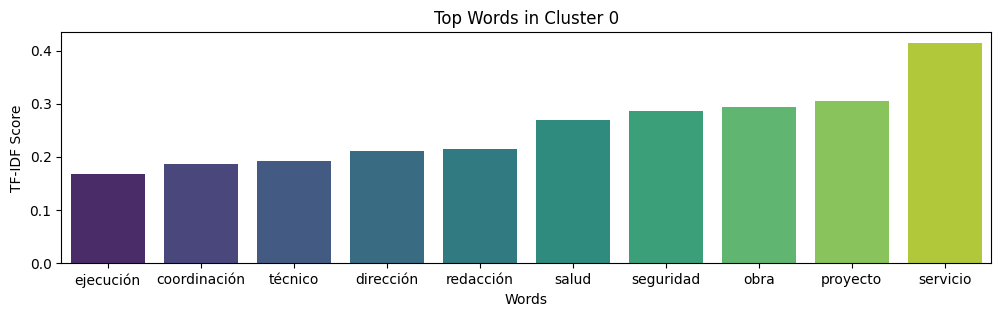

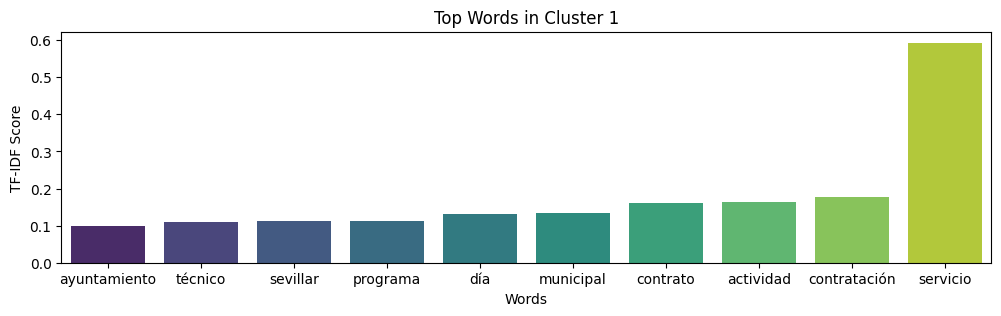

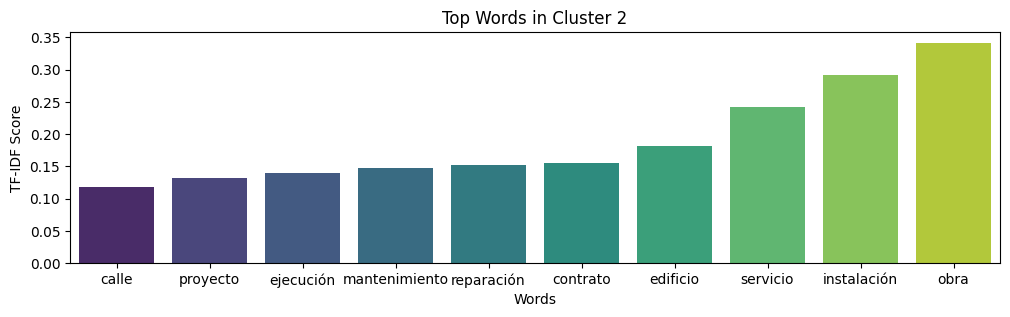

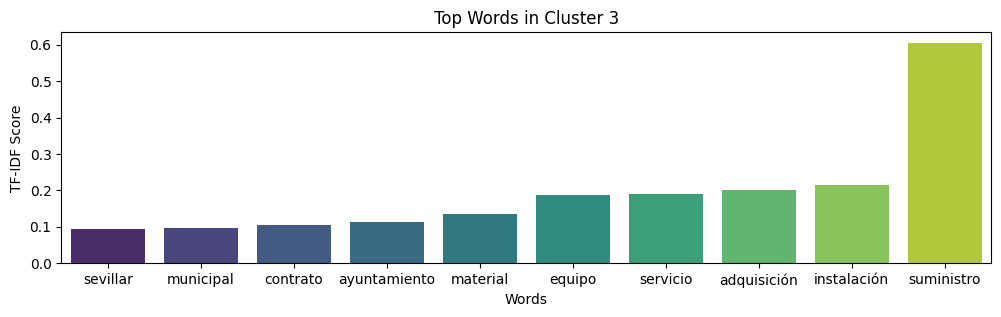

In [26]:
roberta_cluster_labels_4 = roberta_kmeans_models[4].labels_
top_words_roberta_4 = get_top_tfidf_words(descriptions, roberta_cluster_labels_4)
print("RoBERTa Fine-Tuned - 4 Clusters")
print_top_words(top_words_roberta_4)
plot_top_words(top_words_roberta_4)